In [1]:
import os
os.chdir("/workspaces/BAIT")
from analysis.results_utils import load_csv
from figures.fig_utils import *

import torch

In [2]:
# general implementation of jaccard sim
def jaccard_similarity(indices_a, indices_b):
    A = set(indices_a)
    B = set(indices_b)
    nominator = A.intersection(B)
    denominator = A.union(B)
    similarity = len(nominator)/len(denominator)
    return similarity

def jaccard_of_masks(m_a, m_b):
    indices_a = set(m_a.flatten().nonzero().detach().cpu().numpy().flatten())
    indices_b = set(m_b.flatten().nonzero().detach().cpu().numpy().flatten())
    return jaccard_similarity(indices_a, indices_b)

def compare_files(file_a, file_b):
    from analysis.results_utils import get_tensors

    masks_a = get_tensors(files=[file_a], kind="mask")
    masks_b = get_tensors(files=[file_b], kind="mask")

    masks_at = [entry["t"] for entry in masks_a]
    indices_a = torch.concat([m.flatten() for m in masks_at]).nonzero().squeeze().tolist()
    masks_bt = [entry["t"] for entry in masks_b]
    indices_b = torch.concat([m.flatten() for m in masks_bt]).nonzero().squeeze().tolist()

    return jaccard_similarity(indices_a, indices_b)


In [8]:
df = load_csv()

file_a = "standard_o10_snip_0.01_6_20220523231812592640"
file_b = "standard_o10_snip_0.005_6_20220523190229084583"

compare_files(file_a, file_b)

get_tensors found 3 tensors
get_tensors found 3 tensors


0.19300866447564985

In [6]:
init_strategy = "grasp"
repeat_nr = 0
name = "grasp_o10_SNIPGraSPStacked_0.007"	

df = load_csv()

df = df.pivot_table(index = "base_model_id", columns=["name", "init_strategy", "repeat_nr"], values ="file", aggfunc="sum").melt(ignore_index = False).dropna().reset_index()
df = df.query(f"init_strategy == '{init_strategy}' and repeat_nr == {repeat_nr}")[["base_model_id", "name"]]
df = df.groupby("base_model_id")["name"].apply(list).reset_index()
df["count"] = df["name"].apply(lambda x: len(x))
df[df["name"].apply(lambda x: name not in x)].sort_values("count", ascending = False)


,base_model_id,name,count
0,86b5a034-e11a-11ec-bb79-0242ac120002,"[grasp_o10_grasp_0.004, grasp_o10_mag_0.004, g...",40


# Chapter 6

## Similarity between baselines

In [7]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from analysis.results_utils import load_csv


df = load_csv()
# df = df.sort_values(by="accuracy")
df = df.sort_values(by="final_sparsity")


In [17]:
mapping = {
    "rand": "o1",
    "mag": "i1",
    "snip": "o1",
    "grasp": "o1",
    "synflow": "o10",
}
sparsities = [0.5, 0.2, 0.1, 0.01, 0.005]


baseline_query= " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])


df_bl = df.query(baseline_query).query(f"final_sparsity in {sparsities}").query("init_strategy == 'standard'")
files = df_bl.pivot_table(index="base_model_id", columns="name", values="file", aggfunc="count").dropna().melt(ignore_index=False).reset_index().rename(columns={"value":"file"})

In [18]:
# which inits contain all experiments necessary=


def complete_inits(
        mapping = {
            "rand": "o1",
            "mag": "i1",
            "snip": "o1",
            "grasp": "o1",
            "synflow": "o10",
        }, 
        sparsities = [0.5, 0.2, 0.1, 0.01, 0.005],
    ):

    baseline_query= " or ".join([f'phase_0_strategy == "{algo}" and type_short == "{type}"' for algo, type in mapping.items()])


    df_bl = df.query(baseline_query).query(f"final_sparsity in {sparsities}").query("init_strategy == 'standard'")
    files = df_bl.pivot_table(index="base_model_id", columns="name", values="file", aggfunc="count").dropna().melt(ignore_index=False).reset_index().rename(columns={"value":"file"})

    return set(files["base_model_id"]), df_bl, files

complete_init_ids, df_bl, files = complete_inits()
complete_init_ids


{'5f1dd52e-dac5-11ec-b7f4-0242ac120004',
 '5f357f8a-dac5-11ec-831d-0242ac120002'}

In [19]:

results = []
for base_model_id in complete_init_ids:
    # base_model_id = "5f1dd52e-dac5-11ec-b7f4-0242ac120004"

    df_bl_init = df_bl[df_bl["base_model_id"] == base_model_id]

    for sparsity in [0.5, 0.2, 0.1, 0.01, 0.005]:
        # sparsity = 0.005
        df_bl_init_sparsity = df_bl_init[df_bl_init["final_sparsity"] == sparsity]
        all_files = set(df_bl_init_sparsity["file"])

        from itertools import product

        for file_a, file_b in list(product(all_files, all_files)):
            alg_a = df_bl.query(f"file == '{file_a}'").iloc[0]["phase_0_strategy"]
            alg_b = df_bl.query(f"file == '{file_b}'").iloc[0]["phase_0_strategy"]
            sim = compare_files(file_a, file_b)
            results.append({
                "Algorithm A": alg_a,
                "Algorithm B": alg_b,
                "Combination": f"{alg_a}-{alg_b}",
                "Sparsity": sparsity,
                "Jaccard Similarity": sim

            })

import seaborn as sns


g = sns.relplot(data=pd.DataFrame(results), x ="Sparsity", y="Jaccard Similarity", hue="Algorithm B", col="Algorithm A", kind="line", err_style="bars", height=4, aspect=.6)
g.set(
    xlim=(1, 0.004),
    ylim=(0, 1),
    xscale="log",
    )

savefig(g, "5_baseline_overlap")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

# compare o and i pairs

In [ ]:
algo, sparsity, init_id

('mag', 0.1, '5f1dd52e-dac5-11ec-b7f4-0242ac120004')

In [ ]:
# endresult: single plot, each line a similarity between o and i
algos = ["mag", "snip", "grasp", "synflow"]
sparsities = [0.5, 0.2, 0.01, 0.005]

mapping = {
    "mag": 1,
    "snip": 1,
    "grasp": 1,
    "synflow": 10
}
df = load_csv()
results = []
for init_id in {'5f1dd52e-dac5-11ec-b7f4-0242ac120004', '5f357f8a-dac5-11ec-831d-0242ac120002'}:
    for sparsity in sparsities:
        for algo in algos:
            df_algo = df.query(f"base_model_id == '{init_id}' and phase_0_strategy == '{algo}' and final_sparsity == {sparsity} and init_strategy == 'standard'")
            o_file= df_algo.query(f"type_short == 'o{mapping[algo]}'").iloc[0]["file"]
            i_file= df_algo.query(f"type_short == 'i{mapping[algo]}'").iloc[0]["file"]
            sim = compare_files(o_file, i_file)
            results.append({
                "Combination": f"{algo}: o{mapping[algo]} - i{mapping[algo]}",
                "Sparsity": sparsity,
                "Jaccard Similarity": sim

            })

g = sns.relplot(data=pd.DataFrame(results), x ="Sparsity", y="Jaccard Similarity", hue="Combination", kind="line", err_style="bars", height=4, aspect=1)
g.set(
    xlim=(1, 0.004),
    ylim=(0, 1),
    xscale="log",
    )

savefig(g, "5_baseline_overlap_o-i")

get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 

get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 tensors
get_tensors found 3 

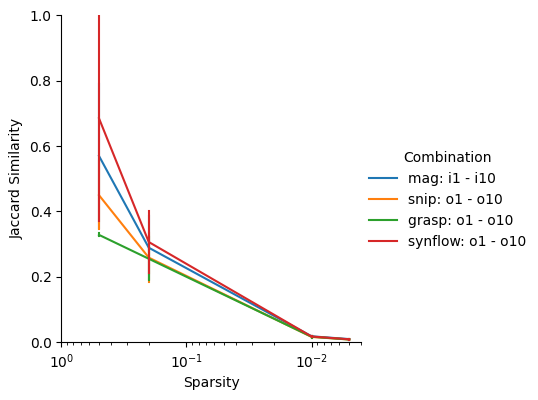

In [ ]:
# endresult: single plot, each line a similarity between o and i
algos = ["mag", "snip", "grasp", "synflow"]
sparsities = [0.5, 0.2, 0.01, 0.005]

mapping = {
    "mag": "i",
    "snip": "o",
    "grasp": "o",
    "synflow": "o"
}
df = load_csv()
results = []
for init_id in {'5f1dd52e-dac5-11ec-b7f4-0242ac120004', '5f357f8a-dac5-11ec-831d-0242ac120002'}:
    for sparsity in sparsities:
        for algo in algos:
            df_algo = df.query(f"base_model_id == '{init_id}' and phase_0_strategy == '{algo}' and final_sparsity == {sparsity} and init_strategy == 'standard'")
            file1 = df_algo.query(f"type_short == '{mapping[algo]}1'").iloc[0]["file"]
            file10= df_algo.query(f"type_short == '{mapping[algo]}10'").iloc[0]["file"]
            sim = compare_files(file1, file10)
            results.append({
                "Combination": f"{algo}: {mapping[algo]}1 - {mapping[algo]}10",
                "Sparsity": sparsity,
                "Jaccard Similarity": sim

            })

g = sns.relplot(data=pd.DataFrame(results), x ="Sparsity", y="Jaccard Similarity", hue="Combination", kind="line", err_style="bars", height=4, aspect=1)
g.set(
    xlim=(1, 0.004),
    ylim=(0, 1),
    xscale="log",
    )

savefig(g, "5_baseline_overlap_1-10")